# **SIC7 | Smart Wellness And Study Companion**

Group Name: 20 bulan mei

Group Members:
- Guntara Hambali
- Muh. Rusmin Nurwadin
- Nahiza Hazim Valensi M
- Reza Ahmad Syarif

In [24]:
import os

# Paksa library dasar untuk pakai 1 thread saja
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

print("Konfigurasi Single-Core diaktifkan untuk simulasi IoT.")

Konfigurasi Single-Core diaktifkan untuk simulasi IoT.


# **Import Library**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

from utils.utils import ResourceMonitor

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# **Load Dataset**

In [26]:
df = pd.read_csv("../data/processed/final_dataset_labeled.csv")

numeric_features = ['Temperature', 'Humidity', 'Light']
categorical_features = ['Pakaian']
target_col = 'Label_Prediksi'

print(f"Jumlah Data: {df.shape[0]} baris, {df.shape[1]} kolom")
display(df.head())

Jumlah Data: 3000 baris, 6 kolom


,Timestamp,Temperature,Humidity,Light,Pakaian,Label_Prediksi
0,2025-12-10 08:00:00,25.506189,54.811749,350,Tipis,Nyaman
1,2025-12-10 08:01:00,25.494481,54.764922,471,Tipis,Nyaman
2,2025-12-10 08:02:00,25.573442,54.918409,451,Tipis,Nyaman
3,2025-12-10 08:03:00,25.549968,55.000000,358,Tipis,Nyaman
4,2025-12-10 08:04:00,25.526797,54.906854,417,Tipis,Nyaman


# **Exploratory Data Analysis (EDA)**

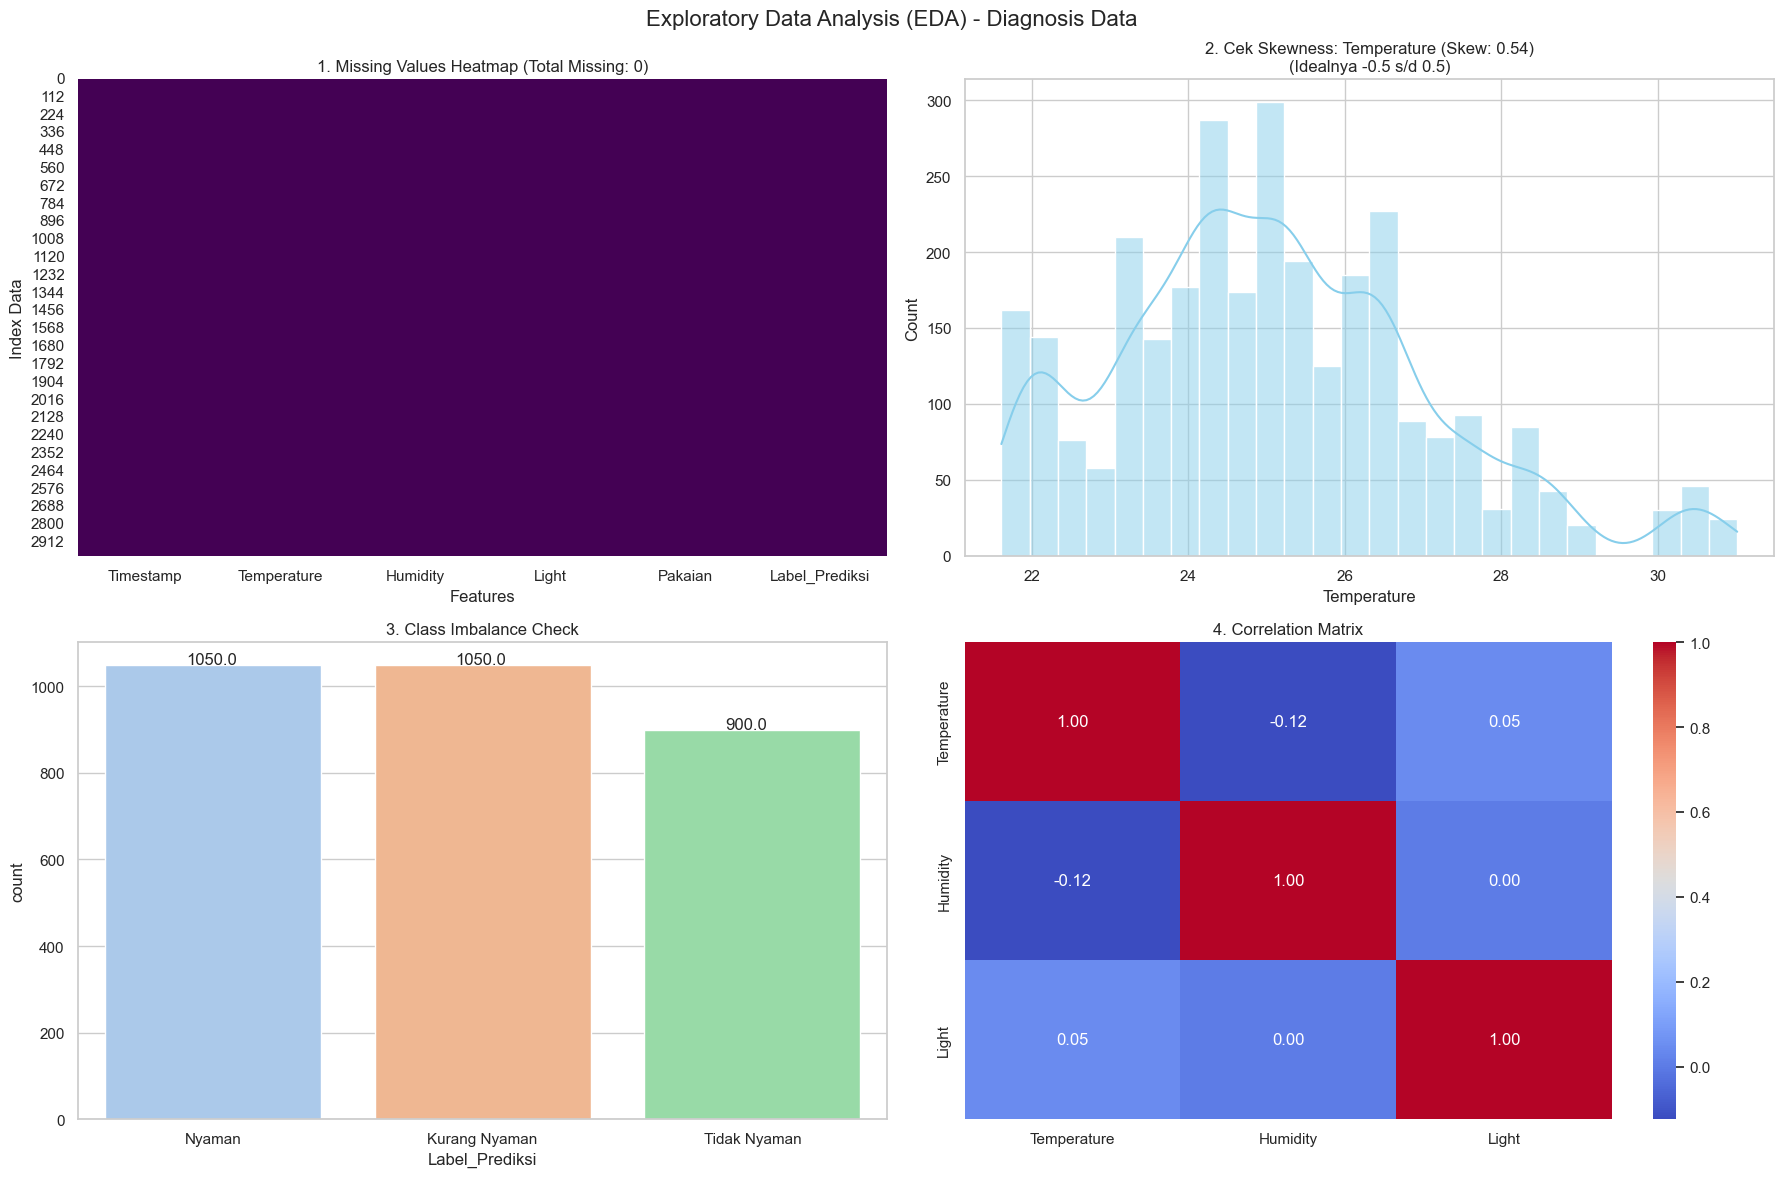


--- Analisis Skewness Lengkap ---
Temperature    0.540983
Humidity       0.943318
Light         -0.012494
dtype: float64


In [27]:
plt.figure(figsize=(18, 12))
plt.suptitle("Exploratory Data Analysis (EDA) - Diagnosis Data", fontsize=16)

# 1. CEK MISSING VALUES
plt.subplot(2, 2, 1)
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
missing_count = df.isnull().sum().sum()
plt.title(f"1. Missing Values Heatmap (Total Missing: {missing_count})")
plt.xlabel("Features")
plt.ylabel("Index Data")

# 2. CEK SKEWNESS (Kemiringan Data Numerik)
plt.subplot(2, 2, 2)
sns.histplot(df['Temperature'], kde=True, color='skyblue')
skew_val = df['Temperature'].skew()
plt.title(f"2. Cek Skewness: Temperature (Skew: {skew_val:.2f})\n(Idealnya -0.5 s/d 0.5)")

# 3. CEK CLASS IMBALANCE (Ketimpangan Label)
plt.subplot(2, 2, 3)
ax = sns.countplot(x=target_col, data=df, palette='pastel')
plt.title("3. Class Imbalance Check")
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 2))

# 4. CEK KORELASI FITUR
plt.subplot(2, 2, 4)
corr = df[numeric_features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("4. Correlation Matrix")

plt.tight_layout()
plt.show()

print("\n--- Analisis Skewness Lengkap ---")
print(df[numeric_features].skew())

# **Splitting Data**

In [28]:
X = df[numeric_features + categorical_features]
y = df[target_col]

# Encode Label Target ke Angka (untuk XGBoost)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Target Mapping: {label_mapping}")

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Data Train: {X_train.shape}")
print(f"Data Test : {X_test.shape}")

Target Mapping: {'Kurang Nyaman': np.int64(0), 'Nyaman': np.int64(1), 'Tidak Nyaman': np.int64(2)}
Data Train: (2100, 4)
Data Test : (900, 4)


# **Preprocessing Pipeline**

In [29]:
# 1. Missing Values & Skewness untuk Data Numerik
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

# 2. Missing Values & Encoding untuk Data Kategorikal
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Pipeline Preprocessing Siap!")

Pipeline Preprocessing Siap!


# **Modeling and Validation**

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        class_weight='balanced', 
        random_state=42, 
        n_jobs=1
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=100, 
        eval_metric='mlogloss', 
        random_state=42, 
        n_jobs=1
    ),
    
    "Decision Tree": DecisionTreeClassifier(
        class_weight='balanced', 
        random_state=42
    ),
    
    "SVM": SVC(
        class_weight='balanced', 
        kernel='rbf', 
        probability=True, 
        random_state=42
    ),
    
    "KNN": KNeighborsClassifier(
        n_neighbors=5, 
        n_jobs=1
    ),
    
    "Logistic Regression": LogisticRegression(
        class_weight='balanced', 
        random_state=42, 
        n_jobs=1
    )
}

results = []
trained_pipelines = {}
monitor = ResourceMonitor(interval=0.05)

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    
    # --- FASE 1: TRAINING (FIT) ---
    monitor.start()
    clf.fit(X_train, y_train)   
    stats_train = monitor.stop()

    # --- FASE 2: EVALUASI ---
    monitor.start()
    y_pred = clf.predict(X_test)
    stats_predict = monitor.stop()
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    acc = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1,
        'Train Time (s)': stats_train['time'],
        'Train CPU (%)': stats_train['cpu_avg'],
        'Train RAM (MB)': stats_train['ram_peak'],
        'Predict Time (s)': stats_predict['time'],
        'Predict CPU (%)': stats_predict['cpu_avg'],
        'Predict RAM (MB)': stats_predict['ram_peak']
    })
    
    trained_pipelines[name] = clf

results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
display(results_df)

,Model,Accuracy,F1-Score,Train Time (s),Train CPU (%),Train RAM (MB),Predict Time (s),Predict CPU (%),Predict RAM (MB)
0,Random Forest,1.000000,1.000000,0.254971,81.940000,380.730469,0.053150,0.0,380.730469
1,XGBoost,1.000000,1.000000,0.152489,127.000000,380.730469,0.051244,0.0,380.753906
2,Decision Tree,1.000000,1.000000,0.051647,0.000000,380.507812,0.050943,0.0,380.523438
4,KNN,1.000000,1.000000,0.051276,0.000000,380.519531,0.050937,0.0,380.515625
3,SVM,0.995556,0.995555,0.152053,50.033333,380.519531,0.050903,0.0,380.515625
5,Logistic Regression,0.856667,0.855818,0.051994,0.000000,380.515625,0.051004,0.0,380.515625


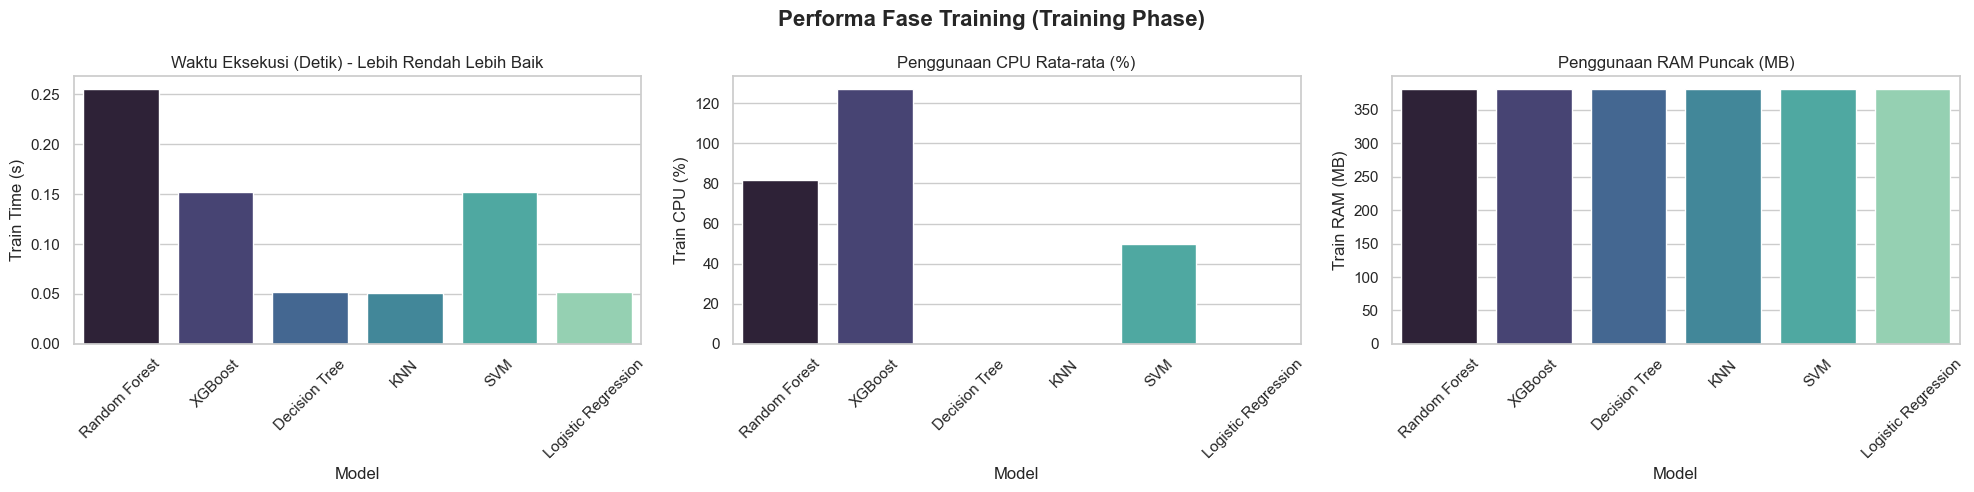

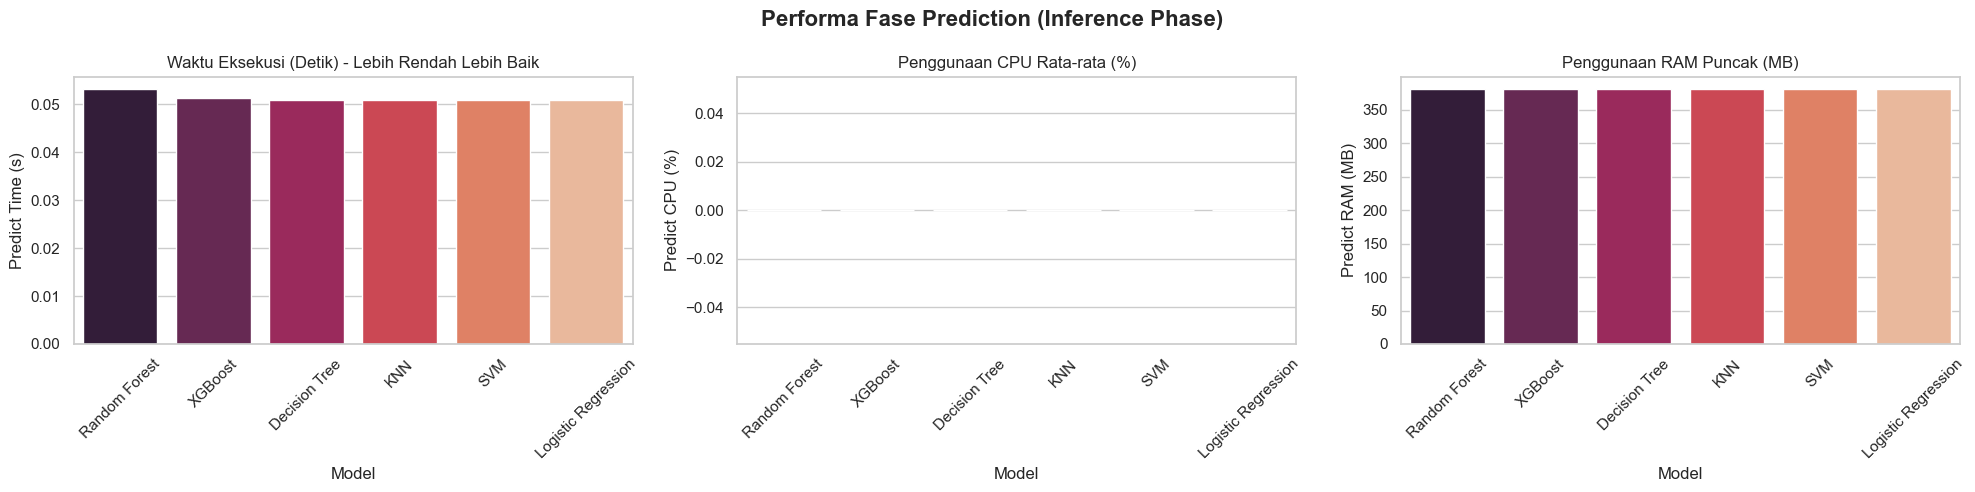

In [ ]:
sns.set(style="whitegrid")

def plot_performance(data, phase="Train"):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f'Performa Fase {phase}ing (Training Phase)' if phase == "Train" else f'Performa Fase {phase}ion (Inference Phase)', fontsize=16, fontweight='bold')
    base_color = "mako" if phase == "Train" else "rocket"
    
    # 1. Plot Time
    sns.barplot(ax=axes[0], x='Model', y=f'{phase} Time (s)', data=data, palette=base_color)
    axes[0].set_title('Waktu Eksekusi (Detik) - Lebih Rendah Lebih Baik')
    axes[0].tick_params(axis='x', rotation=45)
    
    # 2. Plot CPU
    sns.barplot(ax=axes[1], x='Model', y=f'{phase} CPU (%)', data=data, palette=base_color)
    axes[1].set_title('Penggunaan CPU Rata-rata (%)')
    axes[1].tick_params(axis='x', rotation=45)
    
    # 3. Plot RAM
    sns.barplot(ax=axes[2], x='Model', y=f'{phase} RAM (MB)', data=data, palette=base_color)
    axes[2].set_title('Penggunaan RAM Puncak (MB)')
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

plot_performance(results_df, phase="Train")

plot_performance(results_df, phase="Predict")

# **Evaluasi**


=== 1. PERBANDINGAN PERFORMA SEMUA MODEL ===


,Model,Accuracy,F1-Score,Train Time (s),Train CPU (%),Train RAM (MB),Predict Time (s),Predict CPU (%),Predict RAM (MB)
2,Decision Tree,1.000000,1.000000,0.051647,0.000000,380.507812,0.050943,0.0,380.523438
4,KNN,1.000000,1.000000,0.051276,0.000000,380.519531,0.050937,0.0,380.515625
0,Random Forest,1.000000,1.000000,0.254971,81.940000,380.730469,0.053150,0.0,380.730469
1,XGBoost,1.000000,1.000000,0.152489,127.000000,380.730469,0.051244,0.0,380.753906
3,SVM,0.995556,0.995555,0.152053,50.033333,380.519531,0.050903,0.0,380.515625
5,Logistic Regression,0.856667,0.855818,0.051994,0.000000,380.515625,0.051004,0.0,380.515625


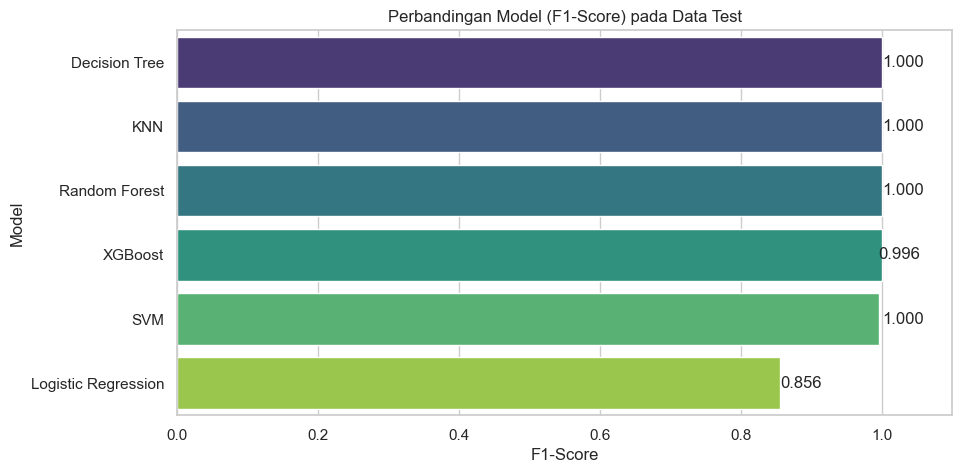


=== 2. DETAIL EVALUASI DATA TEST (Model Terbaik: Decision Tree) ===
Classification Report (Data Test):
               precision    recall  f1-score   support

Kurang Nyaman       1.00      1.00      1.00       315
       Nyaman       1.00      1.00      1.00       315
 Tidak Nyaman       1.00      1.00      1.00       270

     accuracy                           1.00       900
    macro avg       1.00      1.00      1.00       900
 weighted avg       1.00      1.00      1.00       900



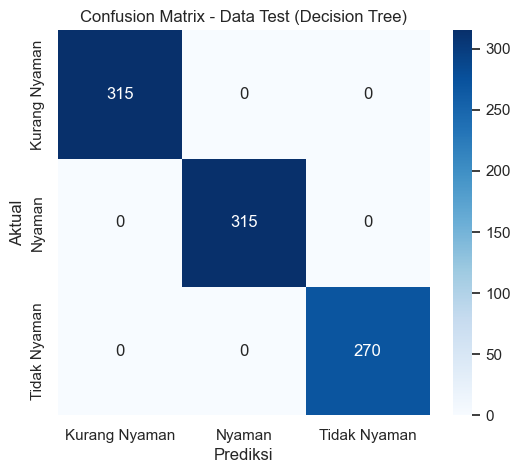

In [32]:
print("\n=== 1. PERBANDINGAN PERFORMA SEMUA MODEL ===")
results_df = pd.DataFrame(results).sort_values(by=['F1-Score', 'Train CPU (%)', 'Train RAM (MB)', 'Train Time (s)'], ascending=[False, True, True, True])
display(results_df)

plt.figure(figsize=(10, 5))
sns.barplot(x='F1-Score', y='Model', data=results_df, palette='viridis')
plt.title('Perbandingan Model (F1-Score) pada Data Test')
plt.xlim(0, 1.1)
for index, row in results_df.iterrows():
    plt.text(row['F1-Score'], index, f"{row['F1-Score']:.3f}", va='center')
plt.show()

best_model_name = results_df.iloc[0]['Model']
best_pipeline = trained_pipelines[best_model_name]

print(f"\n=== 2. DETAIL EVALUASI DATA TEST (Model Terbaik: {best_model_name}) ===")

y_pred_test = best_pipeline.predict(X_test)

y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_test)

print("Classification Report (Data Test):")
print(classification_report(y_test_labels, y_pred_labels))

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - Data Test ({best_model_name})')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.show()

# **Inferensi**

In [ ]:
# print(f"\n=== 3. VALIDASI PADA DATA BARU (External Validation) ===")
# try:
#     best_model = DecisionTreeClassifier(
#         class_weight='balanced', 
#         random_state=42
#     )
    
#     val_file = '../data/processed/validation_dataset_labeled.csv'
#     df_val = pd.read_csv(val_file)
    
#     X_val = df_val[['Temperature (C)', 'Humidity (%)', 'Light (Lux)', 'Pakaian']]
#     y_val_true = df_val['Label']
    
#     print(f"Memuat {len(df_val)} data baru dari '{val_file}'...")
    
#     monitor.start()
    
#     y_val_pred_encoded = best_model.predict(X_val)
    
#     stats_val = monitor.stop()
    
#     y_val_pred_labels = le.inverse_transform(y_val_pred_encoded)
    
#     print("\n[Hasil Benchmarking Sistem]")
#     print(f"• Waktu Eksekusi Total : {stats_val['time']:.4f} detik")
#     print(f"• Latency per Data     : {(stats_val['time']/len(df_val))*1000:.4f} ms")
#     print(f"• CPU Usage (Avg)      : {stats_val['cpu_avg']:.1f} %")
#     print(f"• RAM Usage (Peak)     : {stats_val['ram_peak']:.1f} MB")
    
#     print("\n[Akurasi pada Data Baru]")
#     print(classification_report(y_val_true, y_val_pred_labels))
    
#     plt.figure(figsize=(6, 5))
#     cm_val = confusion_matrix(y_val_true, y_val_pred_labels, labels=le.classes_)
#     sns.heatmap(cm_val, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_, yticklabels=le.classes_)
#     plt.title(f'Confusion Matrix - Data Validasi Baru')
#     plt.ylabel('Aktual (Data Baru)')
#     plt.xlabel('Prediksi Model')
#     plt.show()

# except FileNotFoundError:
#     print(f"⚠️ File '{val_file}' tidak ditemukan. Jalankan kode generate data validation terlebih dahulu.")
# except Exception as e:
#     print(f"⚠️ Terjadi kesalahan saat validasi: {e}")


=== 3. VALIDASI PADA DATA BARU (External Validation) ===
⚠️ File 'train_dummy.csv' tidak ditemukan. Jalankan kode generate data validation terlebih dahulu.


# **Save Model**

In [34]:
filename = "best_model_sic7.pkl"

artifacts = {
    'model': best_pipeline,
    'classes': le.classes_,
    'model_name': best_model_name,
    'metrics': results_df.iloc[0].to_dict()
}

joblib.dump(artifacts, filename)
print(f"Model berhasil disimpan ke {filename}")

Model berhasil disimpan ke best_model_sic7.pkl
